In [521]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

In [522]:
def convert_BGR2RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [523]:
def detect_faces(colored_img):
    img_copy = np.copy(colored_img)
    print("Detecting faces using MediaPipe...")
    mp_face_detection = mp.solutions.face_detection
    face_detection = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)
    results = face_detection.process(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    if not results.detections:
        print("No faces detected.")
        return img_copy, []
    print(f"Number of faces detected: {len(results.detections)}")
    
    cropped_faces = []
    for detection in results.detections:
        bboxC = detection.location_data.relative_bounding_box
        ih, iw, _ = img_copy.shape
        x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)
        x = max(0, x)
        y = max(0, y)
        w = min(iw - x, w)
        h = min(ih - y, h)
        cv2.rectangle(img_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cropped_face = img_copy[y:y+h, x:x+w]
        cropped_faces.append(cropped_face)
    
    return img_copy, cropped_faces

def enhance_contrast(image):
    print("Applying HDR effect...")
    if len(image.shape) != 3 or image.shape[2] != 3:
        print("Error: Input image is not in the correct format. Expected a BGR image.")
        return image
    
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    l = cv2.equalizeHist(l)
    
    scale_factor = image.shape[0] / 1024
    clahe = cv2.createCLAHE(clipLimit=1.7 * scale_factor, tileGridSize=(int(10 * scale_factor), int(10 * scale_factor)))
    l = clahe.apply(l)
    
    lab = cv2.merge((l, a, b))
    enhanced_image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    enhanced_image = cv2.convertScaleAbs(enhanced_image, alpha=1.3, beta=-50)
    
    return enhanced_image

def highlight_skin_issues(face_img):
    print("Highlighting skin issues...")
    enhanced_img = enhance_contrast(face_img)
    
    lab_img = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2LAB)
    
    l_channel, a_channel, b_channel = cv2.split(lab_img)
    
    lower_a = np.array([147])
    upper_a = np.array([160])
    
    red_mask = cv2.inRange(a_channel, lower_a, upper_a)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 1))
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    
    # Использование MediaPipe для получения landmarks лица и создания маски кожи
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)
    results = face_mesh.process(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
    
    if results.multi_face_landmarks:
        mask = np.zeros(face_img.shape[:2], dtype="uint8")
        for face_landmarks in results.multi_face_landmarks:
            points = np.array([(int(pt.x * face_img.shape[1]), int(pt.y * face_img.shape[0])) for pt in face_landmarks.landmark])
            
            face_contour_indices = [
                10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288,
                397, 365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136,
                172, 58, 132, 93, 234, 127, 162, 21, 54, 103, 67, 109
            ]
            face_contour = points[face_contour_indices]
            cv2.drawContours(mask, [face_contour], -1, 255, thickness=cv2.FILLED)
            
            # Exclude
            MESH_ANNOTATIONS = {
                'lips': [
                    61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 146, 91, 181, 84, 17,
                    314, 405, 321, 375, 291, 78, 191, 80, 81, 82, 13, 312, 311, 310,
                    415, 308, 95, 88, 178, 87, 14, 317, 402, 318, 324
                ],
                'leftEye': [
                    263, 249, 390, 373, 374, 380, 381, 382, 362, 466, 388, 387, 386,
                    385, 384, 398, 467, 260, 259, 257, 258, 286, 414, 359, 255, 339,
                    254, 253, 252, 256, 341, 463, 342, 445, 444, 443, 442, 441, 413,
                    446, 261, 448, 449, 450, 451, 452, 453, 464, 372, 340, 346, 347,
                    348, 349, 350, 357, 465
                ],
                'rightEye': [
                    33, 7, 163, 144, 145, 153, 154, 155, 133, 246, 161, 160, 159, 158,
                    157, 173, 247, 30, 29, 27, 28, 56, 190, 130, 25, 110, 24, 23, 22,
                    26, 112, 243, 113, 225, 224, 223, 222, 221, 189, 226, 31, 228, 229,
                    230, 231, 232, 233, 244, 143, 111, 117, 118, 119, 120, 121, 128, 245
                ],
                'leftEyebrow': [
                    265, 353, 276, 283, 282, 295, 383, 300, 293, 334, 296, 336, 285, 417
                ],
                'rightEyebrow': [
                    35, 124, 46, 53, 52, 65, 156, 70, 63, 105, 66, 107, 55, 193
                ]
            }
            
            for key in MESH_ANNOTATIONS:
                idx_list = MESH_ANNOTATIONS[key]
                region_points = points[idx_list]
                if len(region_points) > 0:
                    region_contour = np.array(region_points, dtype=np.int32)
                    cv2.drawContours(mask, [region_contour], -1, 0, thickness=cv2.FILLED)
            
            skin_mask = cv2.bitwise_and(red_mask, red_mask, mask=mask)
            display(plt.imshow(skin_mask))
    else:
        print("No face landmarks detected.")
        return face_img
    
    contours, _ = cv2.findContours(skin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Number of potential skin issues detected: {len(contours)}")
    
    min_area = 1e-6 * face_img.shape[0] * face_img.shape[1]
    max_area = 1e-3 * face_img.shape[0] * face_img.shape[1]
    
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area < area < max_area:
            overlay = face_img.copy()
            cv2.drawContours(overlay, [contour], -1, (0, 0, 255), thickness=cv2.FILLED)
            alpha = 0.5 
            face_img = cv2.addWeighted(overlay, alpha, face_img, 1 - alpha, 0)
    
    print("Skin issues highlighted successfully.")
    return face_img

def process_image(image_path):
    print(f"Processing image: {image_path}")
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Image not found.")
        return None, []
    
    img_with_faces, cropped_faces = detect_faces(img)
    
    processed_faces = []
    for idx, face in enumerate(cropped_faces):
        print(f"Processing face {idx+1}...")
        processed_face = highlight_skin_issues(face)
        processed_faces.append(processed_face)
    
    print("Image processing completed.")
    return img_with_faces, processed_faces


## Usage example

Processing image: acne1.jpg
Detecting faces using MediaPipe...
Number of faces detected: 1
Processing face 1...
Highlighting skin issues...
Applying HDR effect...


I0000 00:00:1728931451.392019 25855730 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1728931451.412029 25965401 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Context leak detected, msgtracer returned -1
I0000 00:00:1728931451.450851 25855730 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1728931451.453999 25965415 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728931451.457650 25965419 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Number of potential skin issues detected: 3165
Skin issues highlighted successfully.
Image processing completed.


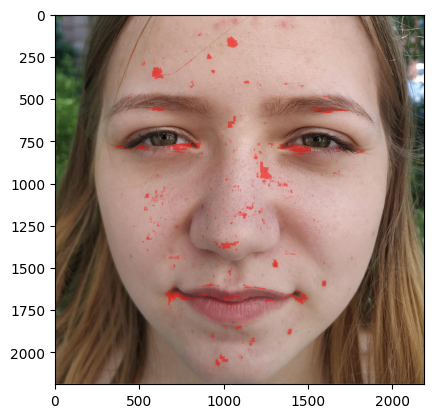

In [524]:
input_image_path = "acne1.jpg"
img_with_faces, processed_faces = process_image(input_image_path)

if img_with_faces is not None:
    display(plt.imshow(convert_BGR2RGB(processed_faces[0]), ))

## Step by step demonstration

#### Input image

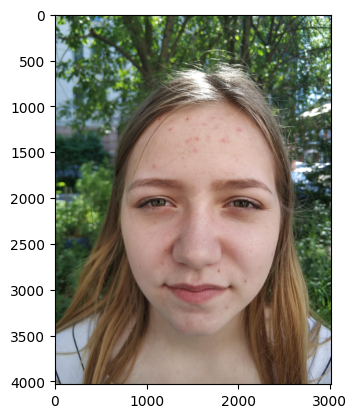

In [525]:
input_image_path = "acne1.jpg"
input_image = cv2.imread(input_image_path)
display(plt.imshow(convert_BGR2RGB(input_image)))

#### Contrast enhancing

Applying HDR effect...


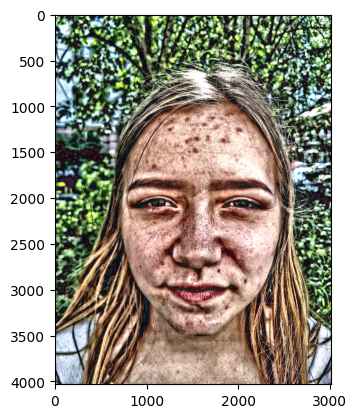

In [526]:
enhanced_contr_image = enhance_contrast(input_image)
display(plt.imshow(convert_BGR2RGB(enhanced_contr_image)))
